In [ ]:
! pip install datasets==2.19.0

In [ ]:
!pip install -q evaluate

# Import Library

In [ ]:
import warnings
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from datasets import load_dataset, load_metric
from transformers import Swinv2ForImageClassification, AutoImageProcessor, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers.integrations import WandbCallback
from transformers import get_linear_schedule_with_warmup
import wandb
import os
from torchvision import transforms
from PIL import Image

# Suppress warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [ ]:
# Load dataset
ds = load_dataset("garythung/trashnet")

In [ ]:
# Definisi label
label_names = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

# Membuat direktori untuk train, val, dan test
base_dir = "trashnet_split"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [ ]:
# Fungsi membuat direktori
def create_dirs(base_dir, label_names):
    for split in ['train', 'val', 'test']:
        split_dir = os.path.join(base_dir, split)
        os.makedirs(split_dir, exist_ok=True)
        for label in label_names.values():
            os.makedirs(os.path.join(split_dir, label), exist_ok=True)

# Buat direktori berdasarkan nama label
create_dirs(base_dir, label_names)

Resize image menjadi 224x224 kemudian Splitting data 70% Train, 15% Validation dan 15% Test

In [ ]:
# Fungsi untuk meresize dan membagi dataset serta menyimpan gambar
def resize_and_split_and_save(dataset, target_size=(224, 224), train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    for label_idx, label_name in label_names.items():
        # Ambil semua gambar dengan label tertentu
        images = [item['image'] for item in dataset['train'] if item['label'] == label_idx]

        # Resize gambar ke target_size (224x224)
        resized_images = [img.resize(target_size) for img in images]

        # Shuffle data
        random.shuffle(resized_images)

        # Hitung jumlah untuk split
        n = len(resized_images)
        train_count = int(n * train_ratio)
        val_count = int(n * val_ratio)

        # Split data
        train_images = resized_images[:train_count]
        val_images = resized_images[train_count:train_count + val_count]
        test_images = resized_images[train_count + val_count:]

        # Simpan ke folder
        for i, img in enumerate(train_images):
            img.save(os.path.join(train_dir, label_name, f"{label_name}_{i}.png"))
        for i, img in enumerate(val_images):
            img.save(os.path.join(val_dir, label_name, f"{label_name}_{i}.png"))
        for i, img in enumerate(test_images):
            img.save(os.path.join(test_dir, label_name, f"{label_name}_{i}.png"))

# Jalankan resize, split, dan simpan
resize_and_split_and_save(ds)

Tampilkan distribusi jumlah gambar per label dari Train, Validation dan Test

In [ ]:
# Direktori dataset yang sudah dibagi
train_dir = '/kaggle/input/trashnet/train'
test_dir = '/kaggle/input/trashnet/test'
val_dir = '/kaggle/input/trashnet/val'

# Fungsi untuk menghitung jumlah gambar per label
def count_images_in_directory(directory):
    label_counts = {}
    for label_name in os.listdir(directory):
        label_path = os.path.join(directory, label_name)
        if os.path.isdir(label_path):
            # Hitung jumlah file gambar dalam folder label
            label_counts[label_name] = len([f for f in os.listdir(label_path) if f.endswith('.png')])
    return label_counts

# Hitung jumlah gambar pada train dan test
train_counts = count_images_in_directory(train_dir)
test_counts = count_images_in_directory(test_dir)
val_counts = count_images_in_directory(val_dir)

# Tampilkan distribusi jumlah gambar per label
print("Distribusi data pada train set:")
for label, count in train_counts.items():
    print(f"{label}: {count} gambar")

print("\nDistribusi data pada test set:")
for label, count in test_counts.items():
    print(f"{label}: {count} gambar")

print("\nDistribusi data pada val set:")
for label, count in val_counts.items():
    print(f"{label}: {count} gambar")

Kompres folder kemudian download dataset tersebut

In [ ]:
# Direktori folder yang ingin diunduh
folder_path = '/kaggle/working/trashnet_split'

# Nama file ZIP yang akan dibuat
zip_filename = '/kaggle/working/trashnet_split.zip'

# Kompres folder menjadi file ZIP
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', folder_path)

# Unduh file ZIP
files.download(zip_filename)

In [4]:
# Memuat dataset dari folder yang sudah ada
data_dir = "/kaggle/input/trashnet"
ds = load_dataset("imagefolder", data_dir=data_dir)
ds

Resolving data files:   0%|          | 0/3535 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/756 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/763 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3535
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 756
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 763
    })
})

In [5]:
ds['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224>,
 'label': 0}

In [6]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    
id2label

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

Memuat model swin transformer

In [7]:
# Memuat model SwinV2 dari Hugging Face
model_name = "microsoft/swinv2-tiny-patch4-window8-256"
image_processor = AutoImageProcessor.from_pretrained(model_name)

In [8]:
# Preprocessing gambar
_transforms = Compose([
    Resize((200, 200)),
    GaussianBlur(kernel_size=(1, 5)),
    RandomAdjustSharpness(sharpness_factor=2),
    RandomEqualize(),
    ToTensor()
])

Kode ``_transforms`` adalah pipeline preprocessing gambar menggunakan pustaka ``torchvision.transforms.Compose.`` Pipeline ini bertujuan untuk mengubah data gambar mentah menjadi format yang dapat digunakan untuk melatih model deep learning. Berikut adalah langkah-langkahnya:

1. ``Resize((200, 200))``:

- Gambar akan diubah ukurannya menjadi 200x200 piksel.

- Hal ini memastikan semua gambar memiliki dimensi yang konsisten sebelum dimasukkan ke dalam model.

2. ``GaussianBlur(kernel_size=(1, 5))``:

- Filter Gaussian diterapkan pada gambar dengan ukuran kernel 1x5.

- Filter ini membantu mereduksi noise pada gambar dengan memberikan efek penghalusan.

3. ``RandomAdjustSharpness(sharpness_factor=2)``:

- Mengubah ketajaman gambar secara acak.

- sharpness_factor=2 berarti gambar dapat menjadi dua kali lebih tajam dari aslinya. Proses ini berguna untuk membuat data lebih bervariasi.

4. ``RandomEqualize()``:

- Histogram gambar diratakan secara acak.

- Proses ini meningkatkan kontras gambar dengan mendistribusikan intensitas piksel lebih merata.

5. ``ToTensor()``:

- Mengonversi gambar dari format PIL Image atau ndarray (NumPy array) menjadi format Tensor PyTorch.

- Tensor ini digunakan sebagai input untuk model deep learning.

In [33]:
# Preprocessing gambar dengan map
def preprocess_train(example):
    example["pixel_values"] = _transforms(example["image"].convert("RGB"))
    return example

train_ds = ds["train"].map(preprocess_train, remove_columns=["image"])
val_ds = ds["validation"].map(preprocess_train, remove_columns=["image"])
test_ds = ds["test"].map(preprocess_train, remove_columns=["image"])

1. Definisi Fungsi ``preprocess_train``:

    - Mengonversi gambar ke format RGB untuk kompatibilitas model.

    - Menerapkan pipeline ``_transforms`` untuk resize, augmentasi, dan konversi ke tensor.

    - Menyimpan hasil preprocessing di kolom baru ``"pixel_values"``.

    - Mengembalikan objek yang telah diproses.

2. Penerapan Preprocessing ke Dataset:

    - Fungsi ``map`` menerapkan ``preprocess_train`` ke dataset (``train``, ``validation``, ``test``).

    - Menghapus kolom asli ``"image"`` dan menggantinya dengan ``"pixel_values"`` yang berisi gambar yang telah diproses.
    - Hasil akhir:

        - ``train_ds``, ``val_ds``, dan ``test_ds`` menjadi dataset dengan kolom ``"pixel_values"`` yang siap digunakan untuk pelatihan model.

In [34]:
train_ds

Dataset({
    features: ['label', 'pixel_values'],
    num_rows: 3535
})

In [35]:
# Memuat model SwinV2
model = Swinv2ForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
model.to("cuda")

Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at microsoft/swinv2-tiny-patch4-window8-256 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=3, bias=False)
                  )
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96

1. ``model``:

    - Swinv2ForImageClassification memuat model SwinV2 untuk tugas klasifikasi gambar.

    - num_labels: Jumlah label kelas dalam dataset.

    - id2label & label2id: Pemetaan antara ID numerik dan nama label.
    
    - ignore_mismatched_sizes=True: Mengabaikan ketidaksesuaian ukuran model (berguna untuk transfer learning).


2. ``model.to("cuda")``:

    - Memindahkan model ke GPU untuk mempercepat proses pelatihan atau inferensi.

In [36]:
# Inisialisasi Wandb
wandb.login()
wandb.init(project="trashnet_classification", entity="ziyad-azzufari")


# Membuat konfigurasi untuk eksperimen
config = wandb.config
config.learning_rate = 1e-4
config.batch_size = 32
config.epochs = 20

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Kode tersebut menginisialisasi Weights & Biases (wandb) untuk melacak eksperimen pelatihan model secara real-time:

1. ``wandb.login()``:

    - Mengautentikasi ke akun wandb untuk memungkinkan pelacakan eksperimen.

2. ``wandb.init(...)``:

    - Memulai proyek baru dengan nama ``trashnet_classification`` dan entitas pengguna ``ziyad-azzufari``. Semua hasil eksperimen akan disimpan di proyek ini.

3. ``config = wandb.config``:

    - Membuat konfigurasi eksperimen yang dapat dicatat dan digunakan untuk dokumentasi atau analisis.

4. Konfigurasi Eksperimen:

    - ``learning_rate = 1e-4``: Nilai learning rate untuk optimizer.

    - ``batch_size = 32``: Ukuran batch untuk pelatihan.
    
    - ``epochs = 20``: Jumlah epoch untuk pelatihan.

Tujuan: Melacak hiperparameter dan hasil eksperimen secara sistematis.

In [37]:
# Optimizer dan Scheduler
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

# Tentukan argumen pelatihan
training_args = TrainingArguments(
    output_dir="swinv2_output",
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_steps=10,
    eval_steps=100,
    learning_rate=config.learning_rate,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    num_train_epochs=config.epochs,
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    report_to="wandb"  # Menggunakan Wandb untuk melacak metrik
)

Kode tersebut mengatur optimizer, scheduler, dan argumen pelatihan untuk model:

1. Optimizer:

    - ``optim.Adam``: Menggunakan algoritma optimisasi Adam untuk memperbarui bobot model selama pelatihan.

        - ``model.parameters()``: Parameter model yang akan dioptimalkan.
        
        - ``lr=config.learning_rate``: Nilai learning rate diambil dari konfigurasi ``wandb``.

2. ``TrainingArguments``: Menentukan konfigurasi untuk pelatihan model:

    - ``output_dir="swinv2_output"``: Direktori untuk menyimpan hasil pelatihan, seperti model yang disimpan.

    - ``evaluation_strategy="steps"`` & ``eval_steps=100``: Mengevaluasi model setiap 100 langkah.

    - ``save_strategy="steps"``: Menyimpan checkpoint model setiap beberapa langkah.

    - ``logging_steps=10``: Melog hasil pelatihan setiap 10 langkah.

    - ``learning_rate=config.learning_rate``: Menggunakan learning rate yang sama seperti di optimizer.

    - ``per_device_train_batch_size=config.batch_size``: Ukuran batch untuk data pelatihan.

    - ``per_device_eval_batch_size=config.batch_size``: Ukuran batch untuk data validasi.

    - ``num_train_epochs=config.epochs``: Jumlah epoch pelatihan.

    - ``metric_for_best_model="f1"``: Menggunakan metrik F1-score untuk memilih model terbaik.

    - ``load_best_model_at_end=True``: Memuat model terbaik di akhir pelatihan.
    
    - ``report_to="wandb"``: Melaporkan metrik ke Weights & Biases untuk pelacakan eksperimen.

Tujuan: Mengatur pelatihan dengan baik, mencatat metrik, dan menyimpan model terbaik.

In [43]:
# Load metric untuk evaluasi
metric = load_metric("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Menghitung Accuracy
    accuracy = accuracy_score(labels, preds)
    
    # Menghitung Precision, Recall, dan F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

Kode tersebut memuat metrik evaluasi dan mendefinisikan fungsi untuk menghitung metrik performa model:

1. ``metric = load_metric("accuracy")``:

    - Memuat metrik bawaan untuk menghitung accuracy.

2. Fungsi ``compute_metrics(pred)``:

- Input:

    - ``pred.label_ids``: Label asli (ground truth).

    - ``pred.predictions.argmax(-1)``: Prediksi model yang diubah menjadi label.
- Proses:

    - Accuracy: Menggunakan ``accuracy_score`` untuk menghitung akurasi.

    - Precision, Recall, F1 Score: Menggunakan ``precision_recall_fscore_support`` dengan rata-rata tertimbang (``average='weighted'``).

- Output: Mengembalikan dictionary berisi nilai akurasi, precision, recall, dan F1 score.

Tujuan: Mengevaluasi performa model secara menyeluruh berdasarkan metrik yang relevan.

In [41]:
# Fungsi collate_fn untuk batching
def collate_fn(batch):
    # Ensure 'pixel_values' are torch tensors
    pixel_values = [torch.tensor(x['pixel_values']) if isinstance(x['pixel_values'], list) else x['pixel_values'] for x in batch]
    return {
        'pixel_values': torch.stack(pixel_values),  # Stack the tensors into a batch
        'labels': torch.tensor([x['label'] for x in batch])
    }


Fungsi ``collate_fn`` digunakan untuk mengatur cara data dalam batch disusun sebelum dimasukkan ke model saat pelatihan:

1. Input:

- ``batch``: Sekumpulan contoh data dari dataset (dalam bentuk dictionary dengan kunci seperti ``'pixel_values'`` dan ``'label'``).

2. Proses:

- ``pixel_values``:
    - Mengecek apakah nilai di ``'pixel_values'`` adalah list, lalu mengonversinya menjadi tensor menggunakan ``torch.tensor``.

    - ``torch.stack(pixel_values)``: Menumpuk tensor menjadi satu batch.
- labels:

    - Mengambil label dari setiap contoh dalam batch dan membuat tensor menggunakan torch.tensor.

3. Output:

- Dictionary berisi:

    - 'pixel_values': Batch gambar dalam format tensor.

    - 'labels': Tensor berisi label dari seluruh data dalam batch.

Tujuan:
Mempersiapkan batch data yang sesuai format untuk input model dalam pelatihan dan evaluasi.

In [44]:
# Scheduler
total_steps = len(train_ds) // training_args.per_device_train_batch_size * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Membuat Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    tokenizer=image_processor,
    optimizers=(optimizer, scheduler),
    callbacks=[WandbCallback()]  # Menambahkan callback Wandb untuk pelatihan
)

# Melatih model
trainer.train()

You are adding a <class 'transformers.integrations.integration_utils.WandbCallback'> to the callbacks of this Trainer, but there is already one. The currentlist of callbacks is
:DefaultFlowCallback
WandbCallback


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.084200,0.304307,0.911376,0.915720,0.911376,0.909353
200,0.122300,0.261402,0.920635,0.924326,0.920635,0.919046
300,0.062500,0.222005,0.935185,0.935859,0.935185,0.935050
400,0.049500,0.248836,0.951058,0.951196,0.951058,0.950683
500,0.066200,0.303174,0.931217,0.931890,0.931217,0.930908
600,0.051100,0.274974,0.936508,0.940276,0.936508,0.935077
700,0.027700,0.270498,0.949735,0.950809,0.949735,0.949769
800,0.013700,0.301515,0.943122,0.945392,0.943122,0.942814
900,0.038900,0.329552,0.953704,0.954903,0.953704,0.953658
1000,0.021700,0.285770,0.957672,0.959815,0.957672,0.956344


TrainOutput(global_step=1120, training_loss=0.06100568554497191, metrics={'train_runtime': 5896.3933, 'train_samples_per_second': 11.99, 'train_steps_per_second': 0.19, 'total_flos': 1.404073222272e+18, 'train_loss': 0.06100568554497191, 'epoch': 20.0})

1. Scheduler:

- Scheduler digunakan untuk menyesuaikan *learning rate* selama pelatihan.
- ``get_linear_schedule_with_warmup``:

    - Membuat linear schedule dengan pengurangan *learning rate* secara bertahap.

    - ``total_steps`` dihitung sebagai total iterasi pelatihan berdasarkan jumlah data, ukuran batch, dan jumlah epoch.

2. Trainer:

- ``Trainer`` adalah kelas bawaan dari Hugging Face yang menyederhanakan pelatihan model.

- Konfigurasi:

    - **Model**: Model yang akan dilatih (``model``).

    - **Args**: Argumen pelatihan seperti batch size, epoch, evaluasi, dll. (dari ``training_args``).

    - **Data Collator**: Fungsi untuk batching data (``collate_fn``).

    - **Datasets**: Dataset pelatihan (``train_ds``) dan validasi (``val_ds``).

    - **Metrics**: Fungsi untuk menghitung metrik evaluasi (c``ompute_metrics``).

    - **Tokenizer**: Preprocessor untuk gambar (``image_processor``).

    - **Optimizers**: Optimizer (``optimizer``) dan scheduler (``scheduler``).
    
    - **Callbacks**: Callback untuk integrasi dengan Wandb (``WandbCallback``).

3. Training:

- ``trainer.train()``: Melakukan pelatihan model berdasarkan konfigurasi di atas, mencatat metrik, dan menyimpan model terbaik.

In [45]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       20.0
  eval_accuracy           =     0.9577
  eval_f1                 =     0.9563
  eval_loss               =     0.2858
  eval_precision          =     0.9598
  eval_recall             =     0.9577
  eval_runtime            = 0:00:50.92
  eval_samples_per_second =     14.846
  eval_steps_per_second   =      0.236


Penjelasan mengenai output evaluasi model:

1. ``epoch``: Menunjukkan epoch terakhir saat evaluasi, yaitu epoch ke-20.

2. ``eval_accuracy``: Akurasi evaluasi model, sebesar 95.77%.

3. ``eval_f1``: Skor F1 pada evaluasi, sebesar 95.63%, yang menggabungkan precision dan recall untuk menilai keseimbangan model.

4. ``eval_loss``: Nilai kerugian (loss) pada evaluasi, sebesar 0.2858, yang menunjukkan seberapa baik model memprediksi data validasi.

5. ``eval_precision``: Precision evaluasi model, sebesar 95.98%, menunjukkan proporsi prediksi positif yang benar.

6. ``eval_recall``: Recall evaluasi model, sebesar 95.77%, menunjukkan proporsi kasus positif yang berhasil terdeteksi.

7. ``eval_runtime``: Waktu yang diperlukan untuk evaluasi, yaitu 50.92 detik.

8. ``eval_samples_per_second``: Jumlah sampel yang dievaluasi per detik, yaitu 14.846.

9. ``eval_steps_per_second``: Jumlah langkah evaluasi per detik, yaitu 0.236.

Secara keseluruhan, hasil evaluasi menunjukkan performa model yang sangat baik dengan akurasi tinggi dan skor F1 yang seimbang.

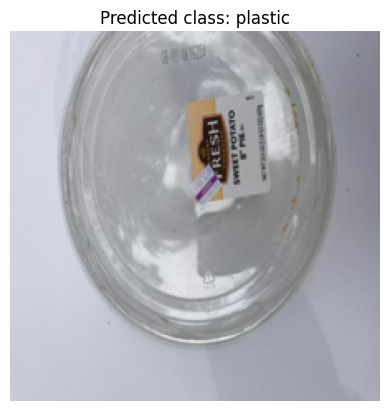

In [55]:
# Pastikan feature_extractor dan model sudah terdefinisi sebelumnya
# torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Load image
url = '/kaggle/input/trashnet/test/plastic/plastic_10.png'
image = Image.open(url)

# Proses gambar dengan feature_extractor
inputs = image_processor(images=image, return_tensors="pt").to(device)

# Melakukan prediksi
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()

# Tampilkan prediksi dan gambar
plt.imshow(image)
plt.title(f"Predicted class: {id2label[predicted_class_idx]}")
plt.axis('off')  # Menghilangkan sumbu
plt.show()

Kode diatas untuk menguji model yang sudah ditraining dan dievaluasi dengan menggunakan 1 sample data test. Hasil prediksi menujukan objek tersebut adalah plastik.

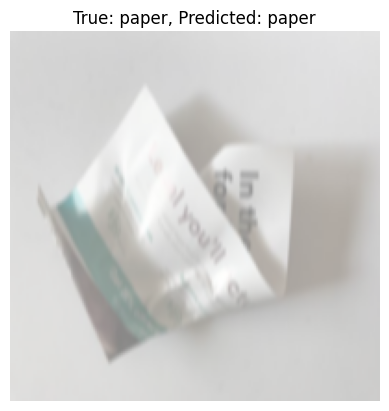

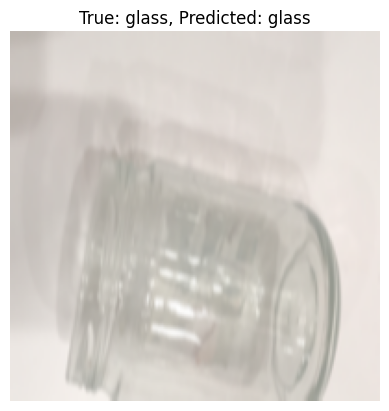

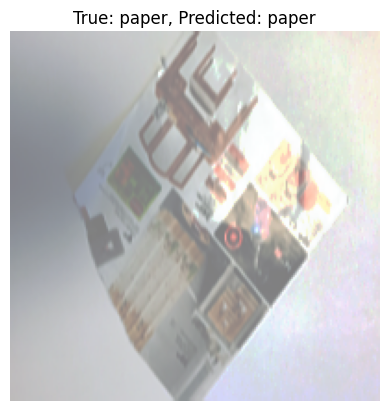

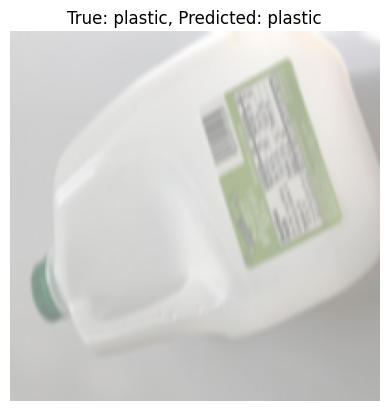

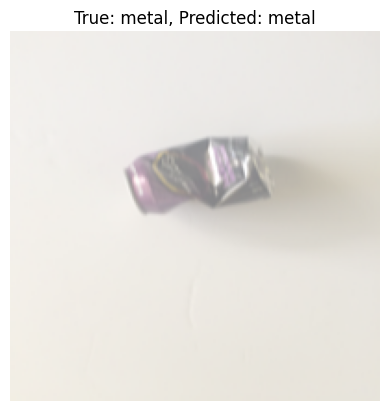

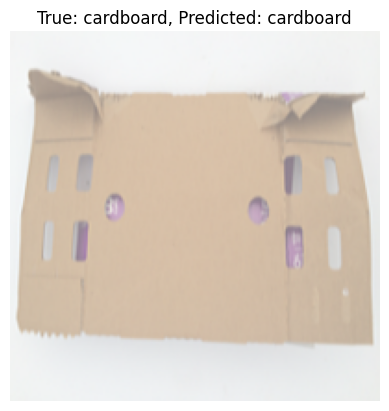

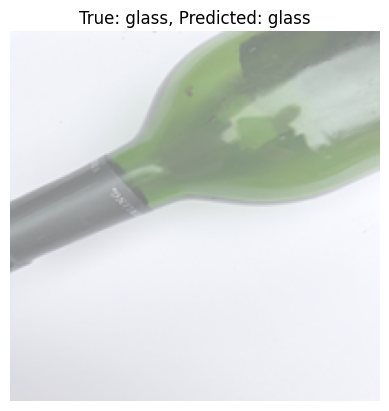

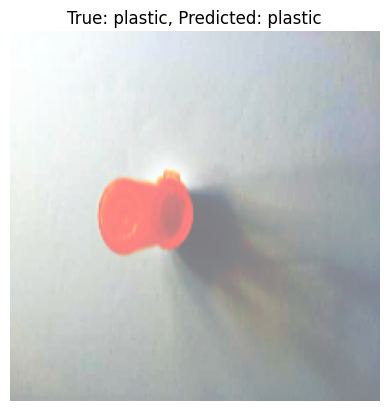

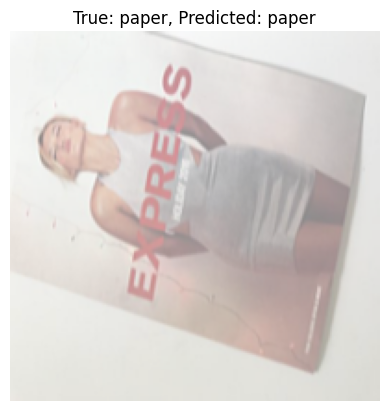

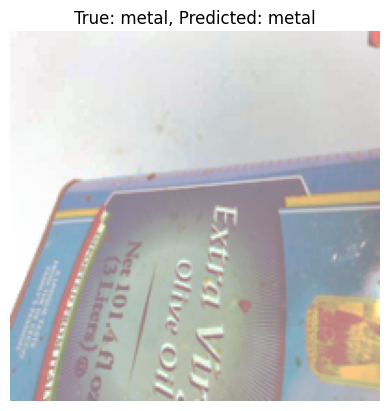

In [61]:
# Fungsi untuk menampilkan gambar dan prediksinya
def show_prediction(image, label, prediction):
    plt.imshow(image)
    plt.title(f"True: {label}, Predicted: {prediction}")
    plt.axis('off')  # Menghilangkan sumbu
    plt.show()

# Pastikan feature_extractor dan model sudah terdefinisi sebelumnya
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Fungsi untuk melakukan prediksi pada satu contoh
def predict_single_image(image):
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return id2label[predicted_class_idx]

# Fungsi untuk mengembalikan pixel values ke gambar asli
def tensor_to_image(tensor):
    tensor = torch.tensor(tensor)  # Convert list to tensor (if it's a list)
    
    # Denormalisasi (jika diperlukan)
    tensor = tensor.squeeze(0)  # Menghapus dimensi batch
    tensor = tensor.permute(1, 2, 0)  # Mengubah bentuk tensor menjadi HWC
    tensor = tensor.cpu().numpy()  # Mengubah tensor ke NumPy array

    # Menyesuaikan rentang nilai
    tensor = (tensor * 0.5 + 0.5) * 255  # Denormalisasi ke 0-255 (asumsi ViT menggunakan standar ini)
    tensor = np.clip(tensor, 0, 255)  # Pastikan nilainya berada dalam rentang [0, 255]
    return tensor.astype(np.uint8)  # Kembalikan ke format uint8 untuk visualisasi

# Pilih beberapa contoh secara acak dari test_ds (misalnya 10 contoh)
for _ in range(10):
    random_idx = random.randint(0, len(test_ds) - 1)  # Pilih indeks acak
    sample = test_ds[random_idx]  # Ambil contoh ke-indeks acak
    pixel_values = sample['pixel_values']
    true_label = sample['label']  # Label asli
    
    # Mengonversi pixel_values tensor menjadi gambar
    image = tensor_to_image(pixel_values)  # Convert tensor to image
    
    # Lakukan prediksi
    predicted_label = predict_single_image(image)
    
    # Tampilkan gambar, label asli, dan prediksi
    show_prediction(image, id2label[true_label], predicted_label)


Kode di atas memuat proses prediksi dan visualisasi untuk gambar dari dataset:

1. Prediksi Gambar: Mengambil gambar acak dari ``test_ds``, mengonversinya menjadi format yang sesuai, dan kemudian melakukan prediksi menggunakan model SwinV2 yang sudah terlatih.

2. Visualisasi: Gambar yang diprediksi beserta label asli dan label prediksi ditampilkan menggunakan ``matplotlib`` dalam bentuk judul yang mencantumkan label yang benar dan prediksi model.

3. Looping: Proses ini diulang untuk 10 contoh gambar secara acak dari dataset test untuk melihat performa model pada beberapa gambar.

Dari 10 sample gambar yang diberikan pada ``test_ds``, model dapat memprediksi semua gambar dengan benar. Kemudian kita akan menguji model pada seluruh ``test_ds``

In [69]:
# Function to perform predictions on a single image
def predict_single_image(image):
    inputs = image_processor(images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_idx = logits.argmax(-1).item()
    return predicted_class_idx  # Return the predicted class index

# Evaluate the model on the test dataset
def evaluate_model(test_ds):
    true_labels = []
    pred_labels = []

    # Loop through the test dataset and collect true and predicted labels
    for sample in test_ds:
        pixel_values = sample['pixel_values']
        true_label = sample['label']
        
        # Convert pixel_values tensor to an image (if necessary for visualization or further processing)
        image = tensor_to_image(pixel_values)  # You can skip this if not needed for visualization
        
        # Get prediction for the image
        predicted_label = predict_single_image(image)
        
        # Store true and predicted labels
        true_labels.append(true_label)
        pred_labels.append(predicted_label)
    
    # Convert lists to numpy arrays for sklearn metrics
    true_labels = np.array(true_labels)
    pred_labels = np.array(pred_labels)
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, pred_labels)
    
    # Classification Report
    report = classification_report(true_labels, pred_labels, target_names=id2label.values())
    
    return cm, report

Kode di atas berfokus pada evaluasi model dengan cara berikut:

1. Prediksi Gambar: Fungsi ``predict_single_image`` menerima gambar sebagai input, memprosesnya, dan mengembalikan indeks kelas yang diprediksi oleh model.

2. Evaluasi Model: Fungsi ``evaluate_model`` melakukan evaluasi pada dataset pengujian (``test_ds``) dengan mengumpulkan label asli dan prediksi untuk setiap gambar.

    - Gambar yang dipilih dari dataset diuji menggunakan fungsi ``predict_single_image``.

    - Hasil prediksi dan label asli disimpan untuk setiap gambar.
    
3. Hasil Evaluasi: Setelah iterasi selesai, fungsi mengonversi label ke dalam format numpy array dan menghitung ``confusion_matrix`` dan ``classification_report`` menggunakan sklearn.

4. Return: ``confusion_matrix`` dan ``classification_report`` dikembalikan untuk analisis lebih lanjut.

In [70]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Fungsi ``plot_confusion_matrix`` memvisualisasikan ``confusion_matrix`` menggunakan heatmap dengan ``sns.heatmap``. ``confusion_matrix`` (cm) akan ditampilkan dengan nilai yang dihitung dari data prediksi, sementara ``classes`` adalah daftar nama kelas untuk label sumbu X dan Y. Fungsi ini akan menampilkan gambar heatmap dengan warna biru dan angka pada setiap sel untuk menunjukkan hasil prediksi terhadap label sebenarnya.

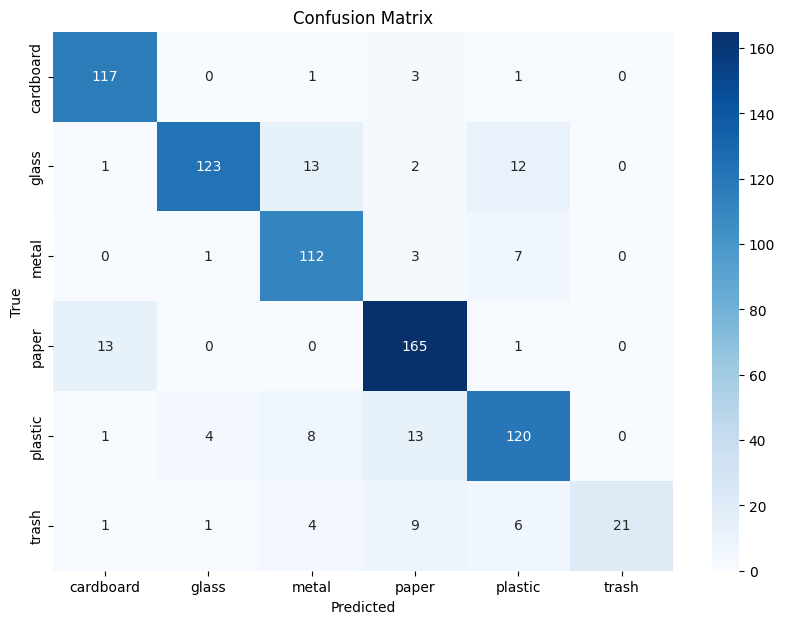

In [71]:
# Run the evaluation
cm, report = evaluate_model(test_ds)

# Get the class names (assuming id2label is defined as a dictionary of class labels)
class_names = list(id2label.values())

# Plot confusion matrix
plot_confusion_matrix(cm, class_names)

Confusion Matrix menunjukan performa model dari enam label: **cardboard**, **glass**, **metal**, **paper**, **plastic**, dan **trash**. Berikut beberapa poin utama:

- Paper memiliki jumlah prediksi benar terbanyak dengan 165 instance dengan 14 kesalahan.

- Cardboard memiliki 117 prediksi benar dengan 5 kesalahan.

- Glass memiliki 123 prediksi benar dengan 28 kesalahan.

- Metal memiliki 112 prediksi benar dengan 11 kesalahan.

- Plastic memiliki 120 prediksi benar dengan 26 kesalahan.

- Trash memiliki 21 prediksi benar dengan 21 kesalahan.

In [72]:
# Print classification report
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

   cardboard       0.88      0.96      0.92       122
       glass       0.95      0.81      0.88       151
       metal       0.81      0.91      0.86       123
       paper       0.85      0.92      0.88       179
     plastic       0.82      0.82      0.82       146
       trash       1.00      0.50      0.67        42

    accuracy                           0.86       763
   macro avg       0.88      0.82      0.84       763
weighted avg       0.87      0.86      0.86       763



Total nilai akurasi untuk data test adalah 86%

In [73]:
trainer.save_model("/kaggle/working/swin")

In [80]:
# Define the directory path
save_dir = "/kaggle/working/swin"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the model and time the process
save_time = time.time()
model.save_pretrained(save_dir)
save_time = time.time() - save_time

print('Save time (sec):', save_time)

Save time (sec): 0.24785852432250977


In [79]:
# Path to the directory you want to zip
dir_path = '/kaggle/working/'

# Path where the zip file will be saved
output_zip_path = '/kaggle/working/data.zip'

# Create a zip file
shutil.make_archive(output_zip_path.replace('.zip', ''), 'zip', dir_path)

'/kaggle/working/data.zip'

Berikut adalah masukan terkait kelebihan dan kekurangan dari proses augmentasi, model, dan hasil berdasarkan penggunaan SwinV2-Tiny dalam proyek:

1. Proses Augmentasi

    Kelebihan:

- Meningkatkan Variasi Data: Augmentasi gambar seperti rotasi, flipping, atau scaling efektif untuk meningkatkan variasi dalam dataset, membantu model mengenali pola lebih robust dan meningkatkan generalisasi.

- Mencegah Overfitting: Dengan memperkenalkan variasi dalam data pelatihan, augmentasi dapat mengurangi kemungkinan model belajar terlalu banyak dari detail spesifik data pelatihan (overfitting), sehingga model lebih bisa diaplikasikan pada data yang belum pernah dilihat sebelumnya.

    Kekurangan:

- Proses Augmentasi yang Terlalu Ekstrem: Augmentasi yang terlalu ekstrem atau tidak realistis (misalnya, perubahan ukuran atau rotasi yang sangat besar) dapat mengubah karakteristik gambar, yang mengarah pada pembelajaran fitur yang tidak relevan, berpotensi menurunkan performa.

- Waktu dan Sumber Daya: Meskipun augmentasi dapat memperkaya data, ini juga menambah beban komputasi dan memori, terutama untuk dataset besar, karena gambar yang telah diaugmentasi akan meningkatkan jumlah total data yang harus diproses.

2. Model (SwinV2-Tiny)

    Kelebihan:

- Efisiensi dan Kecepatan: Dengan ukuran model yang lebih kecil, SwinV2-Tiny lebih cepat dan lebih efisien dalam hal penggunaan memori. Ini sangat berguna jika bekerja dengan perangkat keras yang terbatas (misalnya GPU dengan memori terbatas atau kecepatan pemrosesan rendah).

- Kemampuan Transformer: SwinV2 menggunakan mekanisme window attention, yang membantu dalam mengatasi masalah terkait pengolahan gambar besar dengan efisien, membuatnya sangat cocok untuk tugas-tugas visi komputer dengan input gambar besar atau resolusi tinggi.

- Kinerja yang Baik: SwinV2-Tiny memberikan kinerja yang cukup baik untuk banyak tugas visi komputer meskipun ukurannya kecil. Dengan menggunakan transformer, model ini dapat menangkap pola-pola dalam gambar dengan lebih baik dibandingkan dengan model CNN tradisional.

    Kekurangan:

- Keterbatasan pada Data Kompleks: Karena merupakan model yang lebih kecil (Tiny), model ini mungkin tidak mampu mengatasi dataset yang sangat kompleks atau tugas-tugas yang membutuhkan representasi fitur yang lebih mendalam. Untuk dataset besar atau tugas yang lebih rumit, model dengan ukuran yang lebih besar (misalnya SwinV2-Base atau SwinV2-Large) mungkin memberikan hasil yang lebih baik.

- Overfitting pada Dataset Kecil: Meskipun model ini lebih ringan, pada dataset yang lebih kecil atau sangat terbatas, model ini bisa jadi terlalu kuat untuk data yang ada, yang berisiko menyebabkan overfitting, meskipun augmentasi membantu untuk mengurangi masalah ini.

3. Hasil

    Kelebihan:

- Akurasi yang Tinggi: Berdasarkan classification report yang ditampilkan, model memberikan hasil yang cukup baik dengan akurasi 86% dan f1-score yang stabil untuk kelas-kelas utama (misalnya kardus, kaca, dan plastik). Ini menunjukkan bahwa model mampu membedakan kelas-kelas tersebut dengan baik.

- Kinerja yang Konsisten pada Berbagai Kelas: Model menunjukkan hasil yang baik secara umum pada sebagian besar kelas dengan precision dan recall yang tinggi untuk sebagian besar kategori, meskipun ada perbedaan dalam kinerja antar kelas (misalnya, kelas trash dengan recall 50%).

    Kekurangan:

- Imbalance pada Beberapa Kelas: Hasil yang lebih rendah pada kelas trash (recall 50%) menunjukkan adanya ketidakseimbangan dalam dataset. Model lebih sulit untuk memprediksi kelas yang jarang muncul (kelas dengan sedikit sampel), yang dapat mengurangi akurasi keseluruhan.

- Kesulitan pada Kelas Minoritas: Meskipun akurasi keseluruhan cukup baik, kelas-kelas minoritas (seperti trash) mungkin tidak diprediksi dengan baik. Ini sering terjadi pada model berbasis pembelajaran mesin yang tidak diatur untuk menangani ketidakseimbangan kelas dengan benar.